### Carga del dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/DailyDelhiClimateTrain.csv')
print(df.head())
print(df.info())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None


### Parseo de fecha e índice temporal

In [3]:
# Convertir a datetime y ordenar por fecha
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

### Seleccionar una variable univariante (TS)

In [4]:
#Serie temporal con frecuencia diaria
y = df['meantemp'].asfreq('D')  # frecuencia diaria (D)

# Comprobar valores faltantes
print("Valores NaN:", y.isna().sum())

# Rellenar huecos por interpolación si existen
y = y.interpolate()



Valores NaN: 0


### Visualización

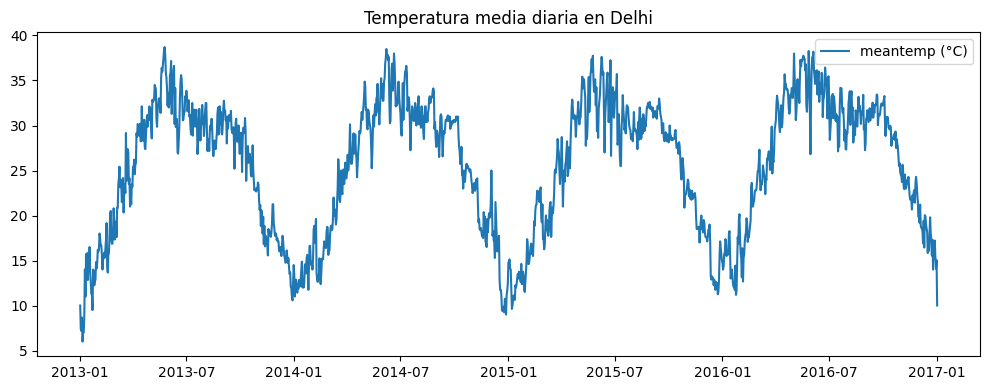

In [5]:
plt.figure(figsize=(10,4))
plt.plot(y, label='meantemp (°C)')
plt.title('Temperatura media diaria en Delhi')
plt.legend()
plt.tight_layout()
plt.show()

### Estacionariedad y diferenciación (ARIMA)
ARIMA necesita (idealmente) una TS estacionaria (media/varianza constantes). Podemos aplicar diferenciación (I de ARIMA) si hay tendencia.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


### Test de estacionariedad (ADF)

In [7]:
adf_stat, pval, *_ = adfuller(y.dropna())
print(f"ADF Statistic: {adf_stat:.3f} - p-value: {pval:.4f}")
if pval < 0.05:
    print("Serie estacionaria: No requiere diferenciación adicional (d=0)")
else:
    print("Serie NO estacionaria: Probar diferenciación (d=1)")

ADF Statistic: -2.021 - p-value: 0.2774
Serie NO estacionaria: Probar diferenciación (d=1)


In [8]:
# Prueba de Dickey-Fuller aumentada
adf_result = adfuller(y)
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

# ✅ Si p > 0.05, la serie no es estacionaria → aplicar diferenciación
if adf_result[1] > 0.05:
    y_diff = y.diff().dropna()
    print("\nSerie diferenciada creada.")
    y = y_diff

Estadístico ADF: -2.0210690559206714
Valor p: 0.2774121372301609

Serie diferenciada creada.


### División Train/Test

In [9]:
train_size = int(len(y)*0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Tamaño entrenamiento:", len(y_train))
print("Tamaño test:", len(y_test))

Tamaño entrenamiento: 1168
Tamaño test: 293


### Inspección ACF/PACF (visual)

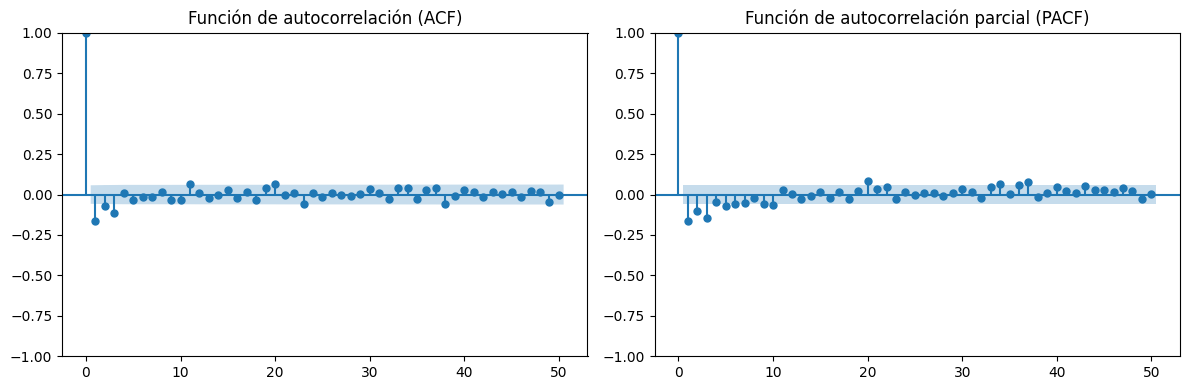

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(y_train.dropna(), lags=50, ax=axes[0])
axes[0].set_title('Función de autocorrelación (ACF)')
plot_pacf(y_train.dropna(), lags=50, ax=axes[1])
axes[1].set_title('Función de autocorrelación parcial (PACF)')
plt.tight_layout()
plt.show()

## Entrenar modelo ARIMA


In [23]:
order = (2, 1, 2)  # Ajusta según lo observado en ACF/PACF/ADF
print(f"Entrenando ARIMA con order={order}")
arima_model = ARIMA(y_train, order=order)
arima_fit = arima_model.fit()
print(arima_fit.summary())

Entrenando ARIMA con order=(2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1168
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2239.976
Date:                Thu, 16 Oct 2025   AIC                           4489.953
Time:                        20:46:59   BIC                           4515.264
Sample:                    01-02-2013   HQIC                          4499.500
                         - 03-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1560      0.030    -38.897      0.000      -1.214      -1.098
ar.L2         -0.1601      0.025     -6.529      0.000      -0.208      -0.112
ma.L1         -

date
2016-03-10    1.562500
2016-03-11   -0.495833
2016-03-12   -0.504167
2016-03-13   -0.312500
2016-03-14   -1.875000
Freq: D, Name: meantemp, dtype: float64
2016-03-15    0.352296
2016-03-16   -0.081187
2016-03-17    0.063301
2016-03-18   -0.034321
2016-03-19    0.055396
Freq: D, Name: predicted_mean, dtype: float64


### Pronóstico (forecasting)

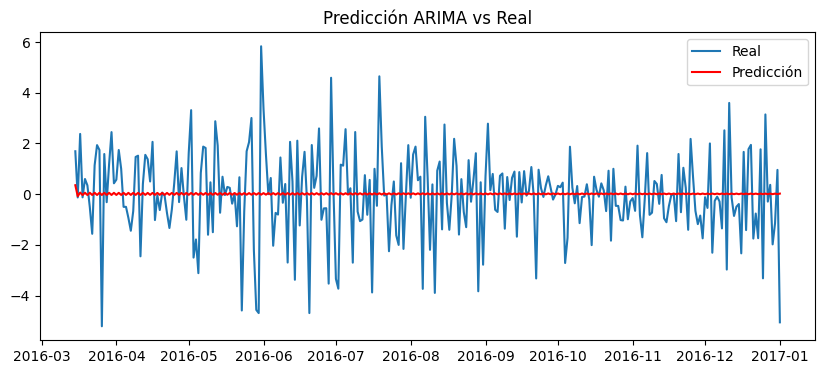

In [20]:
# Predicción para el mismo tamaño del test
forecast = arima_fit.forecast(steps=len(y_test))

# Comparación visual
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, forecast, label='Predicción', color='red')
plt.legend()
plt.title('Predicción ARIMA vs Real')
plt.show()

###  Métricas de predicción

In [13]:
rmse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f}")


RMSE: 2.826 | MAE: 1.256


###  Visualización resultados

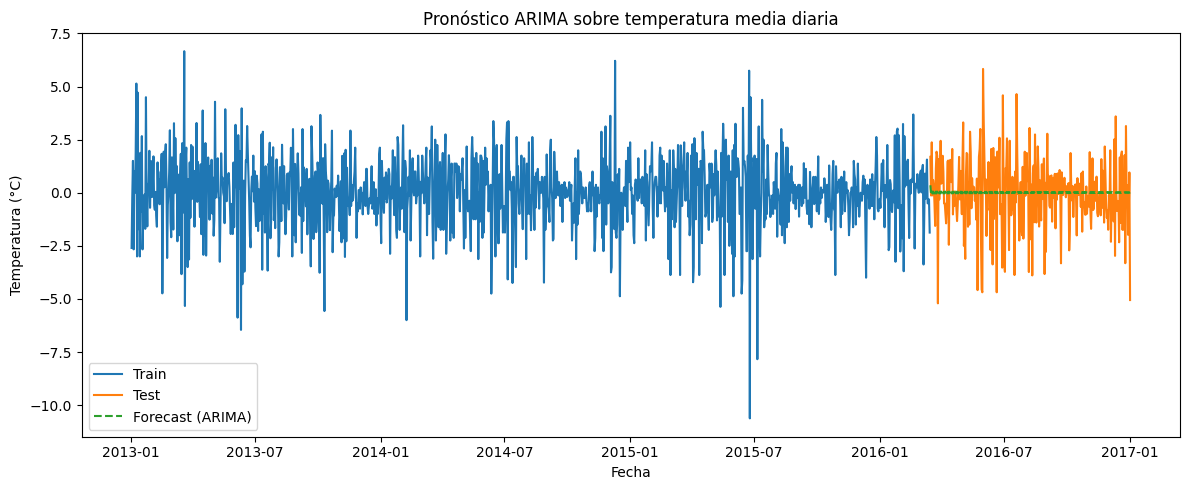

In [21]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test")
plt.plot(y_test.index, forecast, label="Forecast (ARIMA)", linestyle="--")
plt.title('Pronóstico ARIMA sobre temperatura media diaria')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.tight_layout()
plt.show()